# Compare ExaMol to Gaussian G4MP2 computations
G4MP2 with Gaussian is our baseline, and we've validated that it agrees well with experiment for IPs.
Our goal here is to see how well things computed using ExaMol workflows with different flavors of DFT compare.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, kendalltau
from pathlib import Path
from ase import units
import pandas as pd
import json

## Load in the G4MP2 and ExaMol results
They are stored in two different JSON files. 

The G4MP2 is per molecule and it already includes the IE (computed in eV).

In [2]:
g4mp2_data = pd.read_json('./data/g4mp2-mols.json', lines=True)
print(f'Loaded {len(g4mp2_data)} G4MP2 results')

Loaded 3405 G4MP2 results


Load the ExaMol computations, which are stored per-calculation. We'll need to compute IE ourselves

In [3]:
examol_raw_data = []
for path in Path().rglob('optimization.json'):
    print(f'Loading from {path}')
    with path.open() as fp:
        for line in fp:
            record = json.loads(line)
            del record['result']
            examol_raw_data.append(record)
examol_raw_data = pd.DataFrame(examol_raw_data)
print(f'Loaded {len(examol_raw_data)} calculations of {len(set(examol_raw_data.filename))} molecules')

Loading from optimization.json
Loading from output-others/desktop_xtb-mopac/optimization.json
Loaded 666 calculations of 32 molecules


In [4]:
examol_neutral = examol_raw_data.query('charge==0')

In [5]:
examol_oxidize = examol_raw_data.query('charge==1')

In [6]:
examol_data = examol_neutral.merge(examol_oxidize, on=['config_name', 'filename', 'smiles'], suffixes=['_neutral', '_oxidized'])
examol_data['IE'] = examol_data['energy_oxidized'] - examol_data['energy_neutral']

## Compare to G4MP2
Compare each of configurations we've run with ExaMol

In [7]:
total_configs = len(set(examol_data.config_name))
print(f'We have tested {total_configs} configurations')

We have tested 7 configurations


cp2k_b3lyp_svp: MAE - 0.33 V, Offset - -2.21 V
cp2k_b3lyp_tzvpd: MAE - 0.28 V, Offset - -1.89 V
cp2k_blyp_dzvp: MAE - 0.28 V, Offset - -0.70 V
cp2k_blyp_szv: MAE - 0.43 V, Offset - -1.59 V
cp2k_wb97x-d3_tzvpd: MAE - 0.31 V, Offset - -4.43 V
mopac_pm7: MAE - 0.30 V, Offset - -0.28 V
xtb: MAE - 0.51 V, Offset - 4.60 V


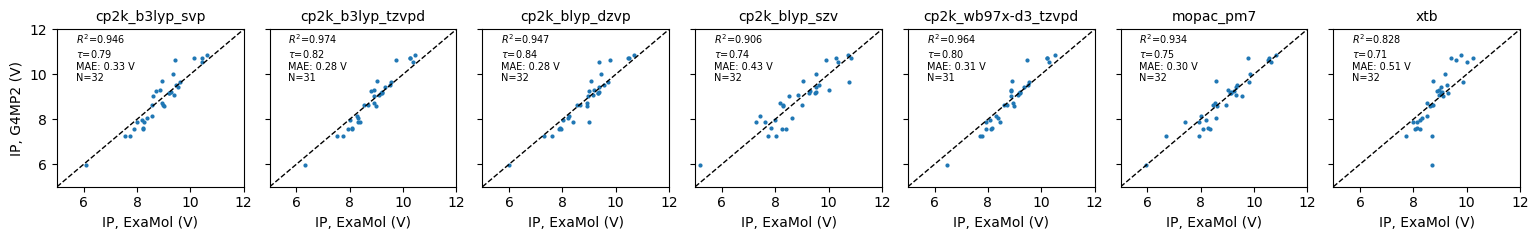

In [8]:
fig, axs = plt.subplots(1, total_configs, sharey=True, figsize=(2.2 * total_configs, 2.5))

for ax, (gid, group) in zip(axs, examol_data.groupby('config_name')):
    ax.set_title(gid, fontsize=10)
    if len(group) < 2:
        continue
    
    # Plot the data
    merged = group.merge(g4mp2_data, on=['filename'])
    r2 = pearsonr(merged['IE'], merged['G4MP2_IP_ASC'])
    tau = kendalltau(merged['IE'], merged['G4MP2_IP_ASC'])
    offset = (merged['IE'] - merged['G4MP2_IP_ASC']).mean()
    mae = ((merged['IE'] - merged['G4MP2_IP_ASC']) - offset).abs().mean()
    print(f'{gid}: MAE - {mae:.2f} V, Offset - {offset:.2f} V')
    ax.scatter(merged['IE'] - offset, merged['G4MP2_IP_ASC'], s=4)
    ax.text(0.1, 0.98, f'$R^2$={r2[0]:.3f}\n$\\tau$={tau[0]:.2f}\nMAE: {mae:.2f} V\nN={len(merged)}', 
           transform=ax.transAxes, va='top', fontsize=7)

    # Plot y=x
    ax.set_xlim(5, 12)
    ax.set_ylim(ax.get_xlim())
    
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

    ax.set_xlabel('IP, ExaMol (V)')

axs[0].set_ylabel('IP, G4MP2 (V)')
fig.tight_layout()
fig.savefig('figures/ionization-potential-validation.png', dpi=320)